In [84]:
import rawpy
import imageio
import torch
import matplotlib.pyplot as plt

path = r"C:/Users/Revi/Desktop/Sony/sony_train/DSC01118.ARW"
with rawpy.imread(path) as raw:
    #rgb = raw.postprocess()
    data = raw.raw_image.copy()
    print(data[0,0])
    #print(raw.raw_image)
    #print(len(raw.raw_image))
    rgb = raw.postprocess()
    print(rgb[0,0])
    imageio.imsave('C:/Users/Revi/Desktop/Sony/aaa.jpeg', rgb)
    
    #print(raw.rgb_xyz_matrix)

800
[ 0 77  0]


In [66]:
import cv2
import numpy as np

width = 5496
height = 3672

with open("C:/Users/Revi/Desktop/Sony/sony_train/DSC01118.ARW", "rb") as rawimg:
    # Read the raw image as uint8
    bayer_im = np.fromfile(rawimg, np.uint8, width * height).reshape(height, width)

bayer_im[0,0]


#https://cs.brown.edu/courses/csci1290/labs/lab_raw/index.html

73

In [96]:
raw_filename = 'C:/Users/Revi/Desktop/Sony/sony_train/DSC01375.ARW'
 
with rawpy.imread(raw_filename) as raw:
    print(f'raw pattern:                  {raw.raw_pattern.tolist()}')          # decribes the pattern of the Bayer sensor
    print(f'CTS Matrix:')
    print(raw.rgb_xyz_matrix)       # camera specific XYZ to camara RGB conversion matrix

raw pattern:                  [[0, 1], [3, 2]]
XYZ to RGB conversion matrix:
[[ 1.0315 -0.439  -0.0937]
 [-0.4859  1.2734  0.2365]
 [-0.0734  0.1537  0.5997]
 [ 0.      0.      0.    ]]


In [104]:
#https://www.numbercrunch.de/blog/2020/12/from-numbers-to-images-raw-image-processing-with-python/

with rawpy.imread(raw_filename) as raw:
    # get raw image data
    image = np.array(raw.raw_image, dtype=np.double)

    # get the raw pattern of the photo
    n_colors = raw.num_colors
    colors = np.frombuffer(raw.color_desc, dtype=np.byte)
    pattern = np.array(raw.raw_pattern)
    i_0 = np.where(colors[pattern] == colors[0])
    i_1 = np.where(colors[pattern] == colors[1])
    i_2 = np.where(colors[pattern] == colors[2])
    i_3 = np.where(colors[pattern] == colors[3])

    # Pack image and average the green channels
    image_packed = np.empty((image.shape[0]//2, image.shape[1]//2, n_colors))
    image_packed[:, :, 0] = image[i_0[0][0]::2, i_0[1][0]::2]
    image_packed[:, :, 1]  = (image[i_1[0][0]::2, i_1[1][0]::2] + image[i_1[0][1]::2, i_1[1][1]::2]) / 2
    image_packed[:, :, 2]  = image[i_2[0][0]::2, i_2[1][0]::2]

    # CTS Conversion
    cts = raw.rgb_xyz_matrix[0:3, :]
    image_sRGB = np.einsum('ij,...j', cts, image_packed)
    print(cts)
    print(image_packed[0,0])
    print(image_sRGB[0,0])


[[ 1.0315 -0.439  -0.0937]
 [-0.4859  1.2734  0.2365]
 [-0.0734  0.1537  0.5997]]
[ 984. 1138. 1352.]
[ 388.73157138 1290.75152087  913.47935992]


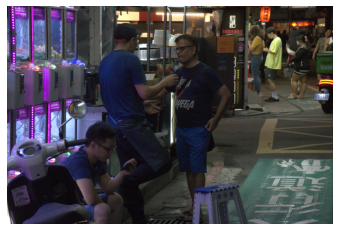

In [88]:
with rawpy.imread(raw_filename) as raw:
    # get raw image data
    image = np.array(raw.raw_image, dtype=np.double)
    # subtract black levels and normalize to interval [0..1]
    black = np.reshape(np.array(raw.black_level_per_channel, dtype=np.double), (2, 2))
    black = np.tile(black, (image.shape[0]//2, image.shape[1]//2))
    image = (image - black) / (raw.white_level - black)
    # find the positions of the three (red, green and blue) or four base colors within the Bayer pattern
    n_colors = raw.num_colors
    colors = np.frombuffer(raw.color_desc, dtype=np.byte)
    pattern = np.array(raw.raw_pattern)
    index_0 = np.where(colors[pattern] == colors[0])
    index_1 = np.where(colors[pattern] == colors[1])
    index_2 = np.where(colors[pattern] == colors[2])
    index_3 = np.where(colors[pattern] == colors[3])
    # apply white balance, normalize white balance coefficients to the 2nd coefficient, which is ususally the coefficient for green
    wb_c = raw.camera_whitebalance 
    wb = np.zeros((2, 2), dtype=np.double) 
    wb[index_0] = wb_c[0] / wb_c[1]
    wb[index_1] = wb_c[1] / wb_c[1]
    wb[index_2] = wb_c[2] / wb_c[1]
    if n_colors == 4:
        wb[index_3] = wb_c[3] / wb_c[1]
    wb = np.tile(wb, (image.shape[0]//2, image.shape[1]//2))
    image_wb = np.clip(image * wb, 0, 1)
    # demosaic via downsampling
    image_demosaiced = np.empty((image_wb.shape[0]//2, image_wb.shape[1]//2, n_colors))
    if n_colors == 3:
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1]  = (image_wb[index_1[0][0]::2, index_1[1][0]::2] + image_wb[index_1[0][1]::2, index_1[1][1]::2]) / 2
        image_demosaiced[:, :, 2]  = image_wb[index_2[0][0]::2, index_2[1][0]::2]
    else: # n_colors == 4
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1] = image_wb[index_1[0][0]::2, index_1[1][0]::2]
        image_demosaiced[:, :, 2] = image_wb[index_2[0][0]::2, index_2[1][0]::2]
        image_demosaiced[:, :, 3] = image_wb[index_3[0][0]::2, index_3[1][0]::2]
    # convert to linear sRGB, calculate the matrix that transforms sRGB into the camera's primary color components and invert this matrix to perform the inverse transformation
    XYZ_to_cam = np.array(raw.rgb_xyz_matrix[0:n_colors, :], dtype=np.double)
    sRGB_to_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                            [0.2126729, 0.7151522, 0.0721750],
                            [0.0193339, 0.1191920, 0.9503041]], dtype=np.double)
    sRGB_to_cam = np.dot(XYZ_to_cam, sRGB_to_XYZ)
    norm = np.tile(np.sum(sRGB_to_cam, 1), (3, 1)).transpose()
    sRGB_to_cam = sRGB_to_cam / norm
    if n_colors == 3:
        cam_to_sRGB = np.linalg.inv(sRGB_to_cam)
    else: # n_colors == 4
        cam_to_sRGB = np.linalg.pinv(sRGB_to_cam)
    image_sRGB = np.einsum('ij,...j', cam_to_sRGB, image_demosaiced)  # performs the matrix-vector product for each pixel
    # apply sRGB gamma curve
    i = image_sRGB < 0.0031308
    j = np.logical_not(i)
    image_sRGB[i] = 323 / 25 * image_sRGB[i]
    image_sRGB[j] = 211 / 200 * image_sRGB[j] ** (5 / 12) - 11 / 200
    image_sRGB = np.clip(image_sRGB, 0, 1)
    # show image
    plt.axis('off')
    plt.imshow(image_sRGB)